# Compute relationship between size and syllable use

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from aging.plotting import figure, legend, format_plots, COLORMAPS, PLOT_CONFIG, save_factory

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig-1-size", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

## Load males

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.copy()

In [5]:
size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
)
age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[m_df.index]

# make sure df matches sizes
m_df = m_df.loc[sizes_col.index]
age = m_df.index.get_level_values("age")

In [6]:
m_df['size'] = sizes_col

## Load females

In [7]:
## arrange data for females
age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df=female_df.copy()

# for female:

# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']

# Save the original index
original_index = f_df.index.names

f_df.reset_index(inplace=True)

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(original_index, inplace=True)

f_df = f_df.query('age<127')

In [8]:
size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
)
# Save the original index
original_index = size_df.index.names
size_df.reset_index(inplace=True)
size_df.loc[size_df['uuid'].isin(uuids), 'age'] = 52
size_df['age'] = size_df['age'].map(age_mapping).fillna(size_df['age'])
# Set the index back
size_df.set_index(original_index, inplace=True)

age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[f_df.index]

# make sure df matches sizes
f_df = f_df.loc[sizes_col.index]
age = f_df.index.get_level_values("age")

In [9]:
f_df['size'] = sizes_col

## Make linear predictions - get r2 scores

In [10]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)

In [11]:
from toolz import valmap

In [12]:
np.random.seed(0)

m_scores = defaultdict(list)
m_shuff_scores = defaultdict(list)

n_repeats = 10
n_shuffles = 100


for syllable in tqdm(m_df.columns[:-1]):

    for i in range(n_repeats):

        preds = cross_val_predict(pipeline, m_df[['size']], m_df[syllable], cv=KFold(n_splits=8, shuffle=True, random_state=i))

        m_scores[syllable].append(r2_score(m_df[syllable], preds))

    # shuffle
    for i in range(n_shuffles):

        y = np.random.permutation(m_df[syllable])

        preds = cross_val_predict(pipeline, m_df[['size']], y, cv=KFold(n_splits=8, shuffle=True, random_state=i))

        m_shuff_scores[syllable].append(r2_score(y, preds))

  0%|          | 0/58 [00:00<?, ?it/s]

In [13]:
p_vals = {}
for syllable in m_scores:
    p = np.mean(np.abs(m_shuff_scores[syllable]) > np.abs(np.mean(m_scores[syllable])))
    p_vals[syllable] = p

is_sig = valmap(lambda x: x < 0.05, p_vals)

In [14]:
np.sum(list(is_sig.values()))

32

In [15]:
np.mean(list(is_sig.values()))

0.5517241379310345

In [16]:
plt_scores = valmap(np.mean, m_scores)
ps = list(plt_scores.values())
bins = np.linspace(np.min(ps), np.max(ps), 9)

webf NOT subset; don't know how to subset; dropped


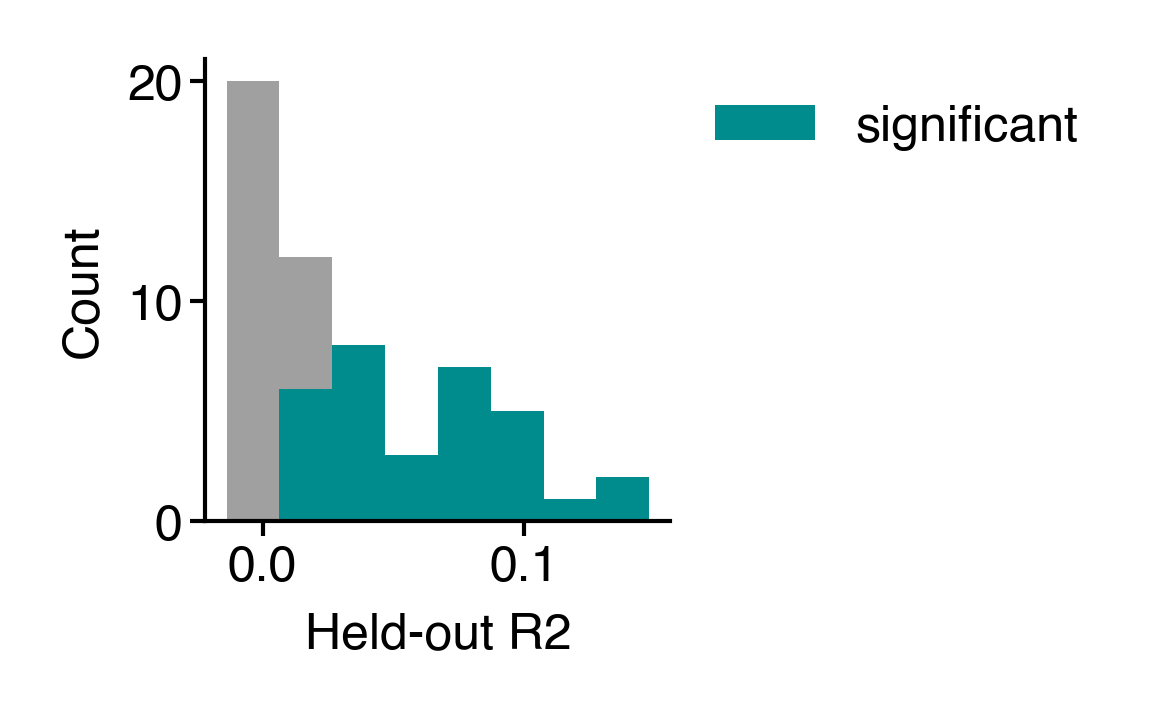

In [17]:
fig = figure(1, 1)
ax = sns.histplot(list(plt_scores.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color='gray')
sns.histplot(list({k: v for k, v in plt_scores.items() if is_sig[k]}.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_male(255), ax=ax, label="significant", alpha=1)
legend(ax)
ax.set(xlabel="Held-out R2")
sns.despine()
saver(fig, "male-r2-vals");

### Get slopes

In [18]:
slope_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)

In [19]:
m_slopes = {}
for syllable in tqdm(m_df.columns[:-1]):
    slope_pipeline.fit(m_df[['size']], m_df[syllable])
    coef = slope_pipeline.named_steps['linearregression'].coef_[0]
    m_slopes[syllable] = coef

  0%|          | 0/58 [00:00<?, ?it/s]

webf NOT subset; don't know how to subset; dropped


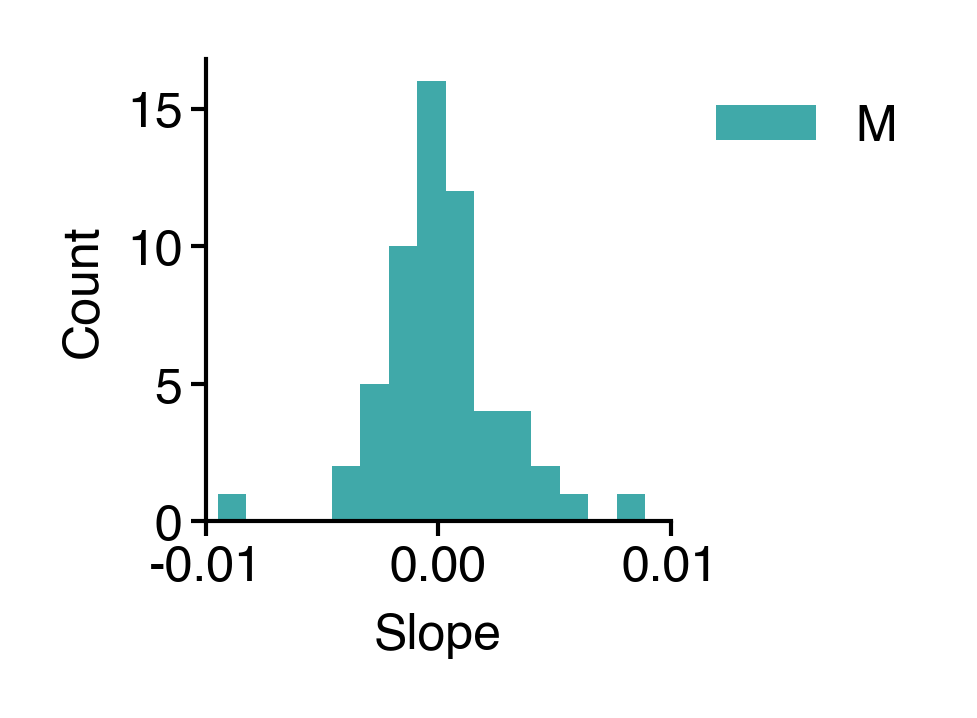

In [20]:
fig = figure(1, 1)
ax = sns.histplot(list(m_slopes.values()), element='step', bins=15, fill=True, stat='count', lw=0, color=COLORMAPS.ont_male(255), label="M")
legend(ax)
ax.set(xlabel="Slope", xlim=(-0.01, 0.01))
sns.despine()
saver(fig, "male-slopes");

In [27]:
dict(sorted(m_slopes.items(), key=lambda x: x[1]))

{62: -0.009470361,
 11: -0.004475301,
 42: -0.004182067,
 70: -0.0032850774,
 69: -0.0029557496,
 2: -0.002791307,
 9: -0.0026858735,
 23: -0.0025357113,
 53: -0.0020996558,
 36: -0.0017923855,
 64: -0.0016732387,
 13: -0.0013722947,
 76: -0.0013195721,
 71: -0.0013155637,
 67: -0.0012036912,
 27: -0.0011103308,
 73: -0.0010636278,
 6: -0.0010341031,
 32: -0.0008681119,
 12: -0.0005781007,
 84: -0.00048104534,
 97: -0.0004483568,
 49: -0.0003422366,
 52: -0.00029454596,
 41: -0.00024765084,
 44: -0.00024343822,
 33: -0.00017030272,
 24: -9.1404494e-05,
 85: -5.6958375e-05,
 93: -2.734255e-05,
 10: 0.00013581276,
 98: 0.00016370363,
 60: 0.0002825949,
 54: 0.00031682017,
 30: 0.00033524304,
 95: 0.00035356593,
 77: 0.00049773086,
 4: 0.0006760156,
 17: 0.0006942457,
 63: 0.0007232918,
 55: 0.00073259394,
 39: 0.0009808682,
 0: 0.0010583979,
 79: 0.0011839885,
 66: 0.0014192682,
 14: 0.0015137924,
 83: 0.0016573305,
 25: 0.001675814,
 16: 0.0018896862,
 90: 0.0024301226,
 68: 0.002813999

## Females

In [29]:
np.random.seed(0)

scores = defaultdict(list)
shuff_scores = defaultdict(list)

n_repeats = 10
n_shuffles = 100


for syllable in tqdm(f_df.columns[:-1]):

    for i in range(n_repeats):

        preds = cross_val_predict(pipeline, f_df[['size']], f_df[syllable], cv=KFold(n_splits=8, shuffle=True, random_state=i))

        scores[syllable].append(r2_score(f_df[syllable], preds))

    # shuffle
    for i in range(n_shuffles):

        y = np.random.permutation(f_df[syllable])

        preds = cross_val_predict(pipeline, f_df[['size']], y, cv=KFold(n_splits=8, shuffle=True, random_state=i))

        shuff_scores[syllable].append(r2_score(y, preds))

  0%|          | 0/58 [00:00<?, ?it/s]

In [30]:
p_vals = {}
for syllable in scores:
    p = np.mean(np.abs(shuff_scores[syllable]) > np.abs(np.mean(scores[syllable])))
    p_vals[syllable] = p

is_sig = valmap(lambda x: x < 0.05, p_vals)

In [31]:
np.sum(list(is_sig.values()))

35

In [32]:
np.mean(list(is_sig.values()))

0.603448275862069

In [33]:
plt_scores = valmap(np.mean, scores)

In [34]:
ps = list(plt_scores.values())

In [35]:
bins = np.linspace(np.min(ps), np.max(ps), 9)

webf NOT subset; don't know how to subset; dropped


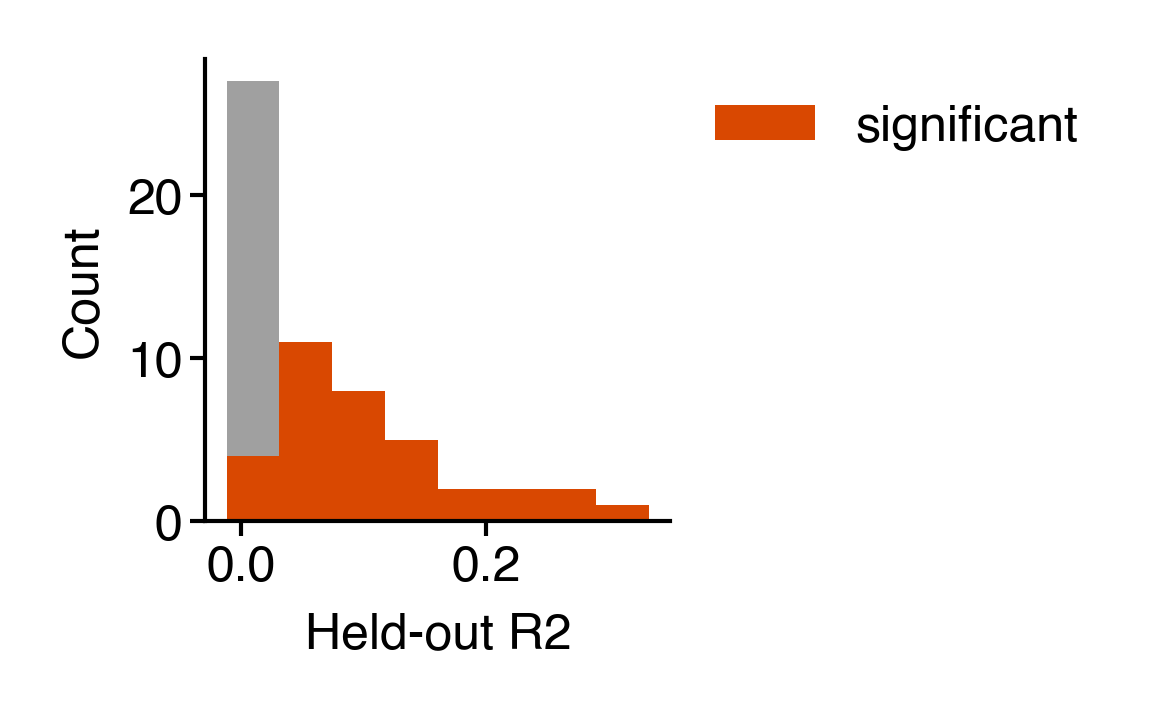

In [36]:
fig = figure(1, 1)
ax = sns.histplot(list(plt_scores.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color='gray')
sns.histplot(list({k: v for k, v in plt_scores.items() if is_sig[k]}.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_female(255), ax=ax, label="significant", alpha=1)
legend(ax)
ax.set(xlabel="Held-out R2")
sns.despine()
saver(fig, "female-r2-vals");

### Get slopes

In [37]:
slope_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression(),
)

In [38]:
f_slopes = {}
for syllable in tqdm(f_df.columns[:-1]):
    slope_pipeline.fit(f_df[['size']], f_df[syllable])
    coef = slope_pipeline.named_steps['linearregression'].coef_[0]
    f_slopes[syllable] = coef

  0%|          | 0/58 [00:00<?, ?it/s]

webf NOT subset; don't know how to subset; dropped


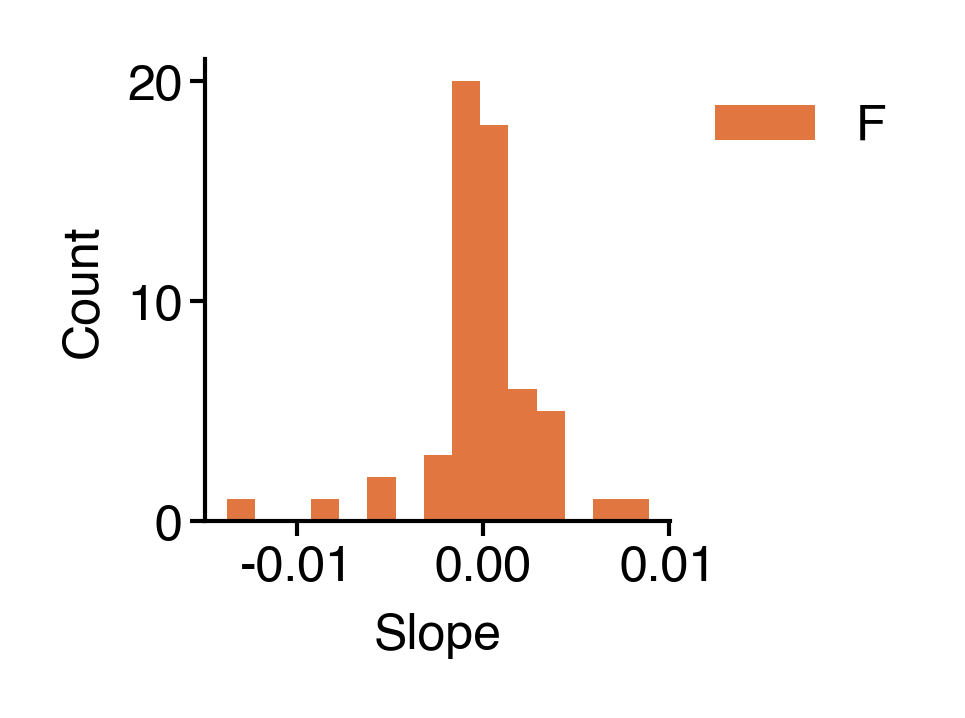

In [39]:
fig = figure(1, 1)
ax = sns.histplot(list(f_slopes.values()), element='step', bins=15, fill=True, stat='count', lw=0, color=COLORMAPS.ont_female(255), label="F")
legend(ax)
ax.set(xlabel="Slope")
sns.despine()
saver(fig, "female-slopes");

In [40]:
dict(sorted(f_slopes.items(), key=lambda x: x[1]))

{62: -0.01381402,
 42: -0.0080585815,
 69: -0.006173394,
 11: -0.0047532343,
 9: -0.002287984,
 53: -0.0020674241,
 12: -0.0016728224,
 41: -0.001203053,
 49: -0.0011009641,
 85: -0.00088482193,
 27: -0.0008397827,
 13: -0.00078082085,
 52: -0.0007386591,
 60: -0.00073476473,
 44: -0.0007290951,
 67: -0.0006725756,
 24: -0.0005521342,
 36: -0.00053268904,
 76: -0.00047617053,
 10: -0.00046513946,
 6: -0.00044283885,
 73: -0.00042000657,
 23: -0.00039480886,
 32: -0.00034790678,
 84: -0.00032648738,
 14: -0.00032260286,
 70: -0.0002620334,
 97: 4.0106243e-05,
 59: 0.0001331088,
 63: 0.00018184248,
 39: 0.00043991403,
 30: 0.00044214565,
 64: 0.00048274273,
 93: 0.0005825262,
 33: 0.00063518627,
 71: 0.00065262744,
 16: 0.00081012293,
 17: 0.000921114,
 54: 0.00092481746,
 55: 0.0009545916,
 77: 0.0010554258,
 83: 0.0011648589,
 90: 0.0011743561,
 98: 0.0012801213,
 95: 0.0013010199,
 0: 0.0015295247,
 68: 0.0018045788,
 61: 0.0018639871,
 79: 0.0021212476,
 18: 0.0024634576,
 74: 0.0025

In [128]:
m_plt_scores = valmap(np.mean, m_scores)

In [134]:
ps = list(plt_scores.values())
bins = np.linspace(np.min(ps), np.max(ps), 11)

webf NOT subset; don't know how to subset; dropped


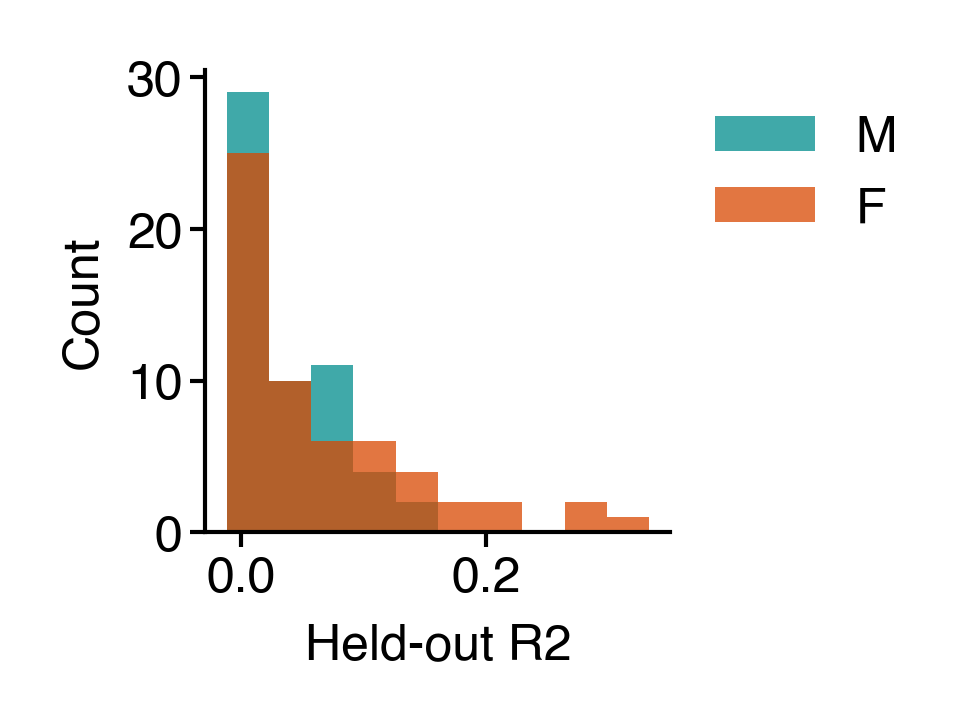

In [135]:
fig = figure(1, 1)
ax = sns.histplot(list(m_plt_scores.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_male(255), label="M")
sns.histplot(list(plt_scores.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_female(255), label="F")
legend(ax)
ax.set(xlabel="Held-out R2")
sns.despine()
saver(fig, "male-female-heldout-r2");

In [139]:
ps = list(f_slopes.values())
bins = np.linspace(np.min(ps), np.max(ps), 15)

webf NOT subset; don't know how to subset; dropped


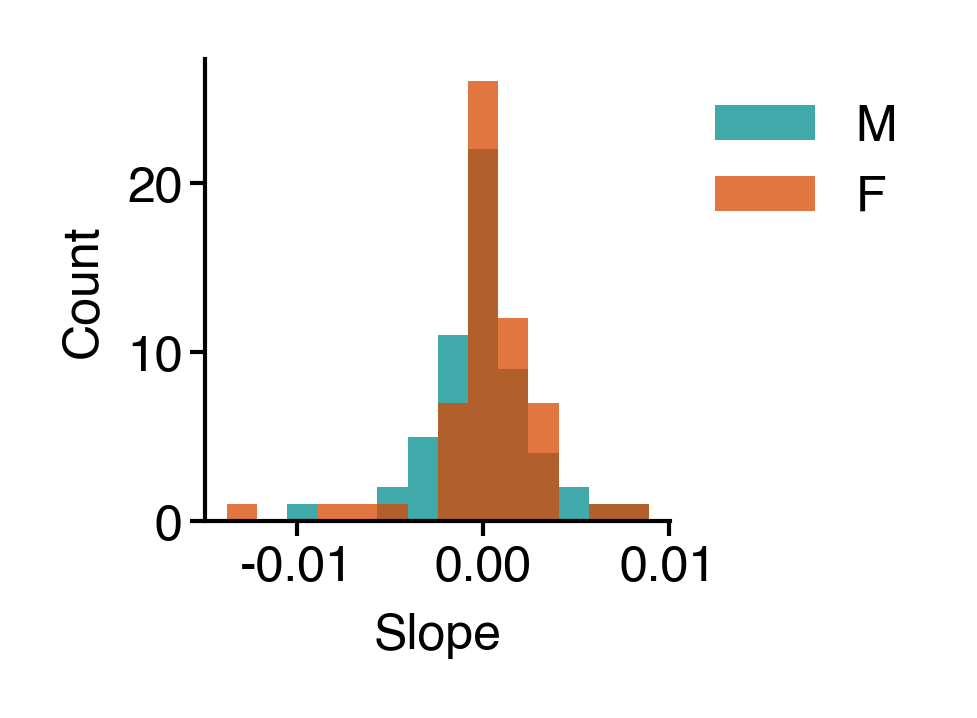

In [140]:
fig = figure(1, 1)
ax = sns.histplot(list(m_slopes.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_male(255), label="M")
sns.histplot(list(f_slopes.values()), element='step', bins=bins, fill=True, stat='count', lw=0, color=COLORMAPS.ont_female(255), label="F", ax=ax)
legend(ax)
ax.set(xlabel="Slope")
sns.despine()
saver(fig, "male-female-slopes");